### To make the installation work, your environment needs these specific tools present at the same time:
-cython<3.0.0 (The compiler)
-cysignals (Interrupt handler)
-scipy (The math library for Bessel functions)
-numpy (The data array library)

In [1]:
import numpy as np
import obspy
from obspy import Stream, Trace
import pyfk
from pyfk import Config, SourceModel, SeisModel

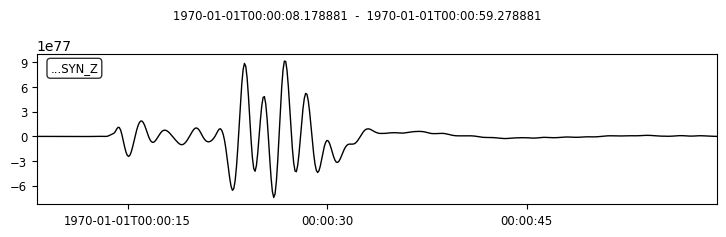

In [10]:
import numpy as np
import obspy
from obspy import Trace
import pyfk
from pyfk import Config, SeisModel, SourceModel

# 1. Earth Model (Based on Lu et al. 2023 / Zhao et al. 2013)
# Format: [thickness(km), vp, vs, rho, qp, qs]
# Note: Thickness of 0.0 in the last row indicates a half-space


model_data = np.array([
    [1.0, 2.00,  3.50, 2.20, 250, 500],  # 0-1km: Sediments
    [4.0, 3.40,  5.80, 2.60, 300, 600],  # 1-5km: Upper Crust
    [10.0, 3.90, 6.20, 2.75, 400, 800],  # 5-15km: High Vs Zone (Magma Chamber)
    [15.0, 3.80, 6.70, 2.90, 400, 800],  # 15-30km: Lower Crust
    [90.0, 4.60,  8.05, 3.35, 500, 1000]  # >30km: Mantle (Half-space)
])
seis_model = SeisModel(model_data)

# 2. Define the Source (M6 event)
# Source depth 21km puts it in the Lower Crust layer
src_model = SourceModel(
    sdep=20.0, 
    source_mechanism=[58, 84, -169, 1.0] 
)

# 3. Simulation Configuration
# Important: receiver_distance must be a 1D array to avoid Buffer dimension errors
delta = 0.1
npts = 512
distances = np.array([80]) # Epicentral distance in km

config = Config(
    model=seis_model, 
    source=src_model,
    receiver_distance=distances, 
    npt=npts,
    dt=delta
)

# 4. Step A: Generate the Green's Functions
# This solves the wave equation for your 1D velocity model
gf_internal = pyfk.calculate_gf(config)

# 5. Step B: Generate the Exponential Source Time Function (STF)
# S(t) = (1/tau) * exp(-t/tau)
tau = 0.1  # Decay constant for M6
t = np.arange(0, npts) * delta
stf_data = (t / tau**2) * np.exp(-t / tau)
stf_data /= np.sum(stf_data) # Normalize to preserve seismic moment

# Wrap STF in an ObsPy Trace
stf_trace = Trace(data=stf_data, header={'delta': delta})

# 6. Step C: Calculate Synthetics
# az=58.0 is the station azimuth relative to the fault
synthetics = pyfk.calculate_sync(
    gf=gf_internal,
    config=config, 
    az=58.0, 
    source_time_function=stf_trace
)

# 7. Extract Results
# calculate_sync returns a list of streams (one per distance)
# Each stream contains: [0]=Vertical(Z), [1]=Radial(R), [2]=Tangential(T)
st_final = synthetics[0] 
tr_z = st_final[0]

# 8. Filter and Plot
# It is always good practice to filter before comparing with real data
tr_z.filter("bandpass", freqmin=0.05, freqmax=0.5)
tr_z.stats.channel = "SYN_Z"
tr_z.plot()

# 9. Save result
#tr_z.write("synthetic_m6_lu2023.mseed", format="MSEED")